# Pedestrian Crash - Trying to predict XYZ at the time of impact
## Read the dataset

Edo tha prospathiso na kano regress to X ti stigmi tou Crash.

## Importing the libraries

In [1]:
# edo eimai, predict XYZ coords in collision. write them in the thesis. Watch out the last layer. It is linear.
# 2) Predict exact collision time.
# 3) Predict relative move rnn
# 4) use kans

from pathlib import Path
import sys
sys.path.insert(0, "C:\\Users\geork\projects\AIThesis\src\src")
import matplotlib.pyplot as plt

from dataset_reader import DatasetReaderCSV

## Read the dataset

In [2]:
path = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_3\\dataset.csv")
reader = DatasetReaderCSV(path)
reader.read()
df = reader.convert_to_dataframe()
df = df.drop(columns=["Id", "Position", "Path", "GifPath", "Head_Collision_XYZ_index", "CarProfile"], errors="ignore")

In [3]:
print(df.dtypes)

Velocity               int64
Translation            int64
Rotation               int64
Head_Collision_X     float64
Head_Collision_Y     float64
Head_Collision_Z     float64
Bumber_Height          int64
Front_Hood_Height      int64
Bumber_Hood_Angle      int64
Hood_Length            int64
Back_Hood_Height       int64
dtype: object


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame
# Define features (X) and targets (y)
X = df.drop(columns=['Head_Collision_X', 'Head_Collision_Y', 'Head_Collision_Z'])
y = df[['Head_Collision_X', "Head_Collision_Y", "Head_Collision_Z"]]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import models, layers, optimizers, losses

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3)  # 3 output neurons for Head_Collision_X, Head_Collision_Y, Head_Collision_Z
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(optimizer="adam", loss="mean_absolute_error")
# model.compile(optimizer="adam", loss=losses.Huber(delta=1.0))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32, 
                    callbacks=[
                        #early_stopping, 
                        reduce_lr])

c:\Users\geork\projects\AIThesis\src\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 471130.1250 - val_loss: 474468.2812 - learning_rate: 0.0010
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 466856.0312 - val_loss: 474279.4375 - learning_rate: 0.0010
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 470957.8125 - val_loss: 473930.4688 - learning_rate: 0.0010
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 474454.1250 - val_loss: 473371.2812 - learning_rate: 0.0010
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 472477.2812 - val_loss: 472639.1562 - learning_rate: 0.0010
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 468553.8750 - val_loss: 471740.6875 - learning_rate: 0.0010
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 463210.4688 - val_loss: 470706.8750 - learning_rate: 0.0010
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 467924.7188 - val_loss: 469319.6250 - learning_rate: 0.0010
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/s

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6996.9253  
Test Loss: 6982.20263671875
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
   Predicted X  Predicted Y  Predicted Z
0   425.291199     5.065899  1130.493408
1   450.890778  -120.599533  1244.013184
2   512.670044   473.593811  1220.527222
3   199.805176    69.626984   992.118958
4   252.358383   164.945297  1122.764404


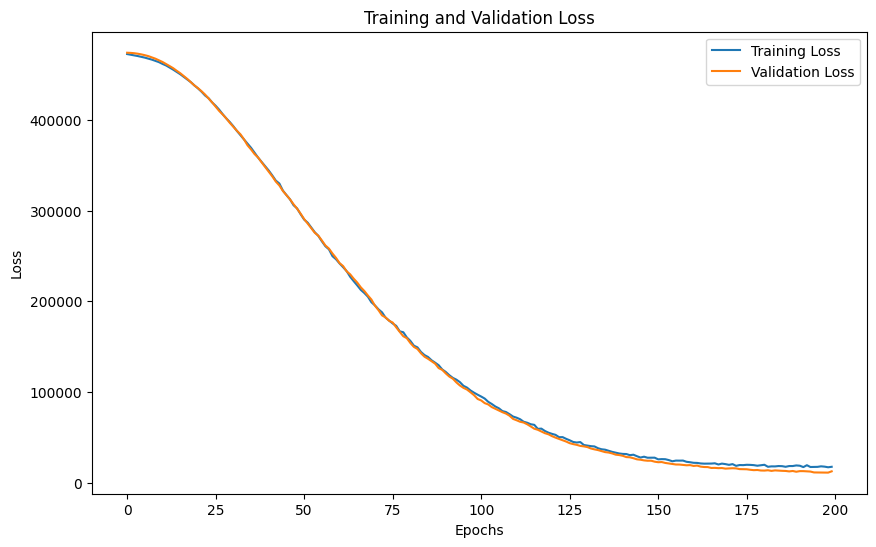

In [6]:
# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(X_test)

# If you want to see the predictions
predictions_df = pd.DataFrame(y_pred, columns=['Predicted X', "Predicted Y", "Predicted Z"])
print(predictions_df.head())

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


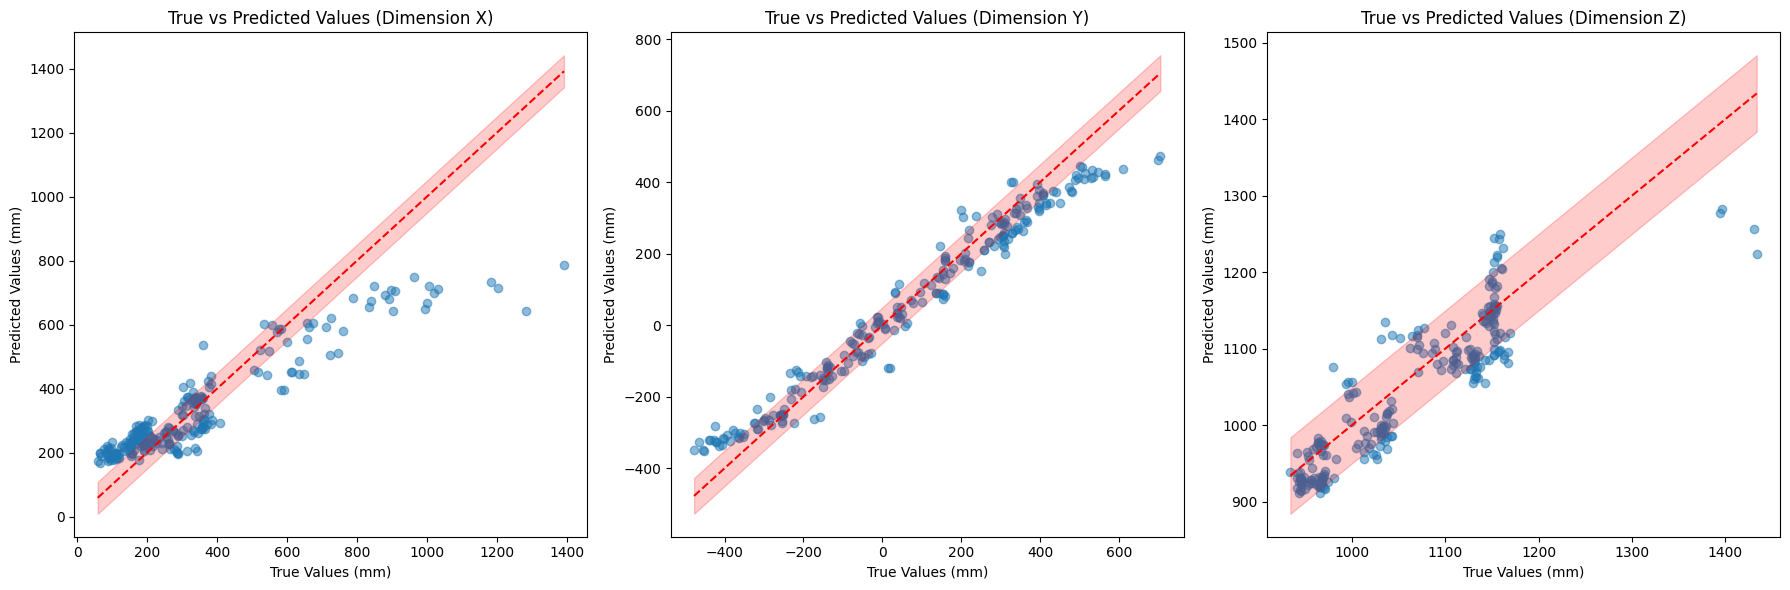

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)

# Assuming y_test is the true values and y_pred are the predictions
y_test = y_test.reset_index(drop=True).rename(columns={'Head_Collision_X': 'True_Head_Collision_X', 
                                                       "Head_Collision_Y": "True_Head_Collision_Y",
                                                       "Head_Collision_Z": "True_Head_Collision_Z"})
y_test_df = y_test
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted_Head_Collision_X',
                                          "Predicted_Head_Collision_Y",
                                          "Predicted_Head_Collision_Z"])

# Merge true and predicted values into a single DataFrame
comparison_df = pd.concat([y_test_df, y_pred_df], axis=1)

# Define the error range in mm
error_range = 50  # 25 mm on each side of the perfect prediction line

# Plot true vs predicted values for each dimension separately
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot with shaded error region
def plot_with_error_region(ax, true_vals, pred_vals, title):
    ax.scatter(true_vals, pred_vals, alpha=0.5)
    ax.set_xlabel('True Values (mm)')
    ax.set_ylabel('Predicted Values (mm)')
    ax.set_title(title)

    # Plot line of perfect prediction
    ax.plot([true_vals.min(), true_vals.max()], 
            [true_vals.min(), true_vals.max()], 
            color='red', linestyle='--')  
    
    # Plot shaded error region
    ax.fill_between([true_vals.min(), true_vals.max()], 
                    [true_vals.min() - error_range, true_vals.max() - error_range],
                    [true_vals.min() + error_range, true_vals.max() + error_range],
                    color='red', alpha=0.2)  # Light red shaded region

# Plot for the first dimension (X)
plot_with_error_region(axes[0], 
                       comparison_df['True_Head_Collision_X'], 
                       comparison_df['Predicted_Head_Collision_X'], 
                       'True vs Predicted Values (Dimension X)')

# Plot for the second dimension (Y)
plot_with_error_region(axes[1], 
                       comparison_df['True_Head_Collision_Y'], 
                       comparison_df['Predicted_Head_Collision_Y'], 
                       'True vs Predicted Values (Dimension Y)')

# Plot for the third dimension (Z)
plot_with_error_region(axes[2], 
                       comparison_df['True_Head_Collision_Z'], 
                       comparison_df['Predicted_Head_Collision_Z'], 
                       'True vs Predicted Values (Dimension Z)')

plt.tight_layout()
plt.show()
